In [61]:
import numpy as np
import pandas as pd
from scipy.constants import g, pi
from math import sqrt, cos, tanh
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.ticker as ticker
# costants

kn_ms = 1000/1852

# Диаграмма Ремеза пример




In [62]:
""" Function convert height of the waves in different systems
        height - input height
        inp_type - identifier of input system:
        out_type - identifier of input system
          identifiers:
            '3p' - 3% height (default)
            '1_3' - 13.5% height (default)
            'mean' - average height
            reference [1] (1.1) (page 18)
    """

def wave_convert(height, inp_type = '1_3', out_type = '3p'):
    coef_matrice = {'3p':{'1_3':1/1.33, 'mean': 1/2.11},
                    '1_3':{'3p':1.33, 'mean': 1.33/2.11 },
                    'mean':{'3p':2.11, '1_3':2.11/1.33}}
    return    height*coef_matrice[inp_type][out_type]

## Параметры волнения

### Параметры регулярного волнения 

[2]:Длина волны: 

$$\lambda=\frac{g}{2\pi}\tau^2=\frac{2\pi}{g}c^2$$


$$\tau=\sqrt{\frac{2\pi\lambda}{g}}=\frac{2\pi}{g}c$$

$$c=\frac{\lambda}{\tau}=\sqrt{\frac{g\lambda}{2\pi}}=\frac{g}{2pi}\tau$$

, где

$\tau$- период волны, с; $\lambda$ - длина волны, м; c - скорость волны, м/с; g - ускорение свободного падения
 
 [2] : формулы 1-3 стр 7

In [63]:
def wave_length(period, k_lambda = 1):
    """ Function calculate  average wave lenght
        k_lamda=0.78 for unregular waves
        reference [1] (1.2) (page 19) 
        k_lambda - 0.5-1 - degree of regularity of waves 1- for regular waves
    """
    l = k_lambda*g/(2*pi)*period**2
    # l = 1.56 * period**2
    return l


In [64]:
def wave_speed(wave_length, depth = None,):
    """ wave speed in knots"""
    if depth is None:
        c = 2.43*sqrt(wave_length)
    else:
        c = 1.95*sqrt(g*wave_length/(2*pi)*tanh(2*pi*depth/wave_length))
    return c

In [26]:
def wave_period_h3p(height_3p, method = 'lipis',  beta = 1, tws = 0):
    """ Function calculate average wave period
        method - lipis
        reference [1] (1.3) (page 19)
        method kozir 
        reference [2] (9) (page 18)
          
    """
    if method == 'lipis':
        period = beta*3.1*sqrt((height_3p))
    elif method == 'kozir':
        period = 18.7*(g*wave_convert(height_3p,'1_3','mean')/tws**2)**(3/5)/(g/tws)
    else:
        period = None
        
    return period



## Параметры судна


In [65]:
# Длина по ВЛ
lwl = 275
# Ширина max
b_max = 44
# Осадка
d = 9.2
# Метацентрическая высота
h = 10.4
lwl

275

## Расчетные данные по судну

In [66]:
# Инерционный коэфиициент
c = 0.373 + 0.023*b_max/d - 0.043*lwl/100

Оптимальный вариант получить периоды собственных колебаний судна из надежных источников. 
Но если их нет возможен приближенный расчет.
Если известны только основные размерения возможно применение капитанских формул [3]:

- период вертикальной качки 

     $\tau_\varsigma=2.5\sqrt{d}$
     
- период килевой качки

    $\tau_\psi=2.4\sqrt{d}$
    
- период бортовой качки
    
    $\tau_\theta=2CB\sqrt{d}$
    
    где d- осадка судна, B - ширина судна, С - инерционный коэффициент равный:
    $$C=0.373 +\frac{0.023B}{d}-\frac{0.043LWL}{100}$$
     
тогда в нашем случае:

In [67]:
# 
# Период собственных пеперечных колебаний 
t_teta = 2*c*b_max/sqrt(h) 
# Период собственных продольных колебаний 
t_fi = 2.4*sqrt(d)
# Период собственных вертикальных колебаний
t_dzeta = 2.5 * sqrt(d)


In [68]:
print('Инерционный коэфиициент', c)
print('Период бортовых колебаний',t_teta)
print('Период продольных колебаний', t_fi)
print('Период вертикальных колебаний',t_dzeta)

Инерционный коэфиициент 0.36475
Период бортовых колебаний 9.953167277111032
Период продольных колебаний 7.279560426289487
Период вертикальных колебаний 7.58287544405155


При известном поперечном моменте инерции период бортовой качки можно вычислить по формулам :
$$\tau_\theta=2\pi\sqrt{\frac{I_x}{Dh}}$$

где
$I_x$ - поперечный момент инерции судна.
Существуют 2 импирических формулы для его оценки

$$I_x=\frac{D}{g}*\bigg(\frac{B^2+4z_g^2}{11}\bigg)$$

либо

$$I_x=\frac{D}{g}*\bigg(\frac{B^2\delta}{10.3\alpha^2}+\frac{H_б^2}{11}\bigg)$$

[4] стр 210

## Расчетные параметры волнения
Если в параметрах волнения присутствует только высота волны, то период волны можно оценить по формуле:

In [69]:
def tau_app(Vs, l_wave, wave_angle):
    tau =1/kn_ms* l_wave/(v_wave + Vs*cos(wave_angle/180*pi))
    return abs(tau)
    

In [70]:
# Высота волны 3%
# h_3p = np.array( [i for i in np.linspace(0,9,7)])
h_3p_cal = 5
# Период волны
h_mean = wave_convert(h_3p_cal,'3p','mean')
print('средняя высота волны', h_mean)
t_wave = wave_period_h3p(h_3p_cal)
print(t_wave)
l_wave  = wave_length(t_wave,1)
# скорость волны

v_wave =  wave_speed(l_wave)
print('v_wave', v_wave)




средняя высота волны 2.3696682464454977
6.931810730249349
v_wave 21.043761603916046


In [71]:
# Параметры движения
# Скорость судна, узл
Vs = 15
# Курсовые углы к волне
wave_angles = np.linspace(0,180,37)
wave_angles


array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180.])

In [72]:
print('period', t_wave)
print('speed',v_wave)
print('speed*period',v_wave*t_wave*kn_ms)
print('l_wave',l_wave)

period 6.931810730249349
speed 21.043761603916046
speed*period 78.76424000585016
l_wave 74.99532632939612


In [73]:
taus_app_0 = np.array([])
taus_app_1 = np.array([])
print(wave_angles)
for wave_angle in wave_angles:
    taus_app_1 = np.append(taus_app_1,
                           abs(l_wave/(1.25*sqrt(l_wave*1)+kn_ms*Vs*cos(wave_angle/180*pi))))#tanh(2*pi*1000/l_wave)
    taus_app_0 = np.append(taus_app_0,tau_app(Vs, l_wave, wave_angle))

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180.]


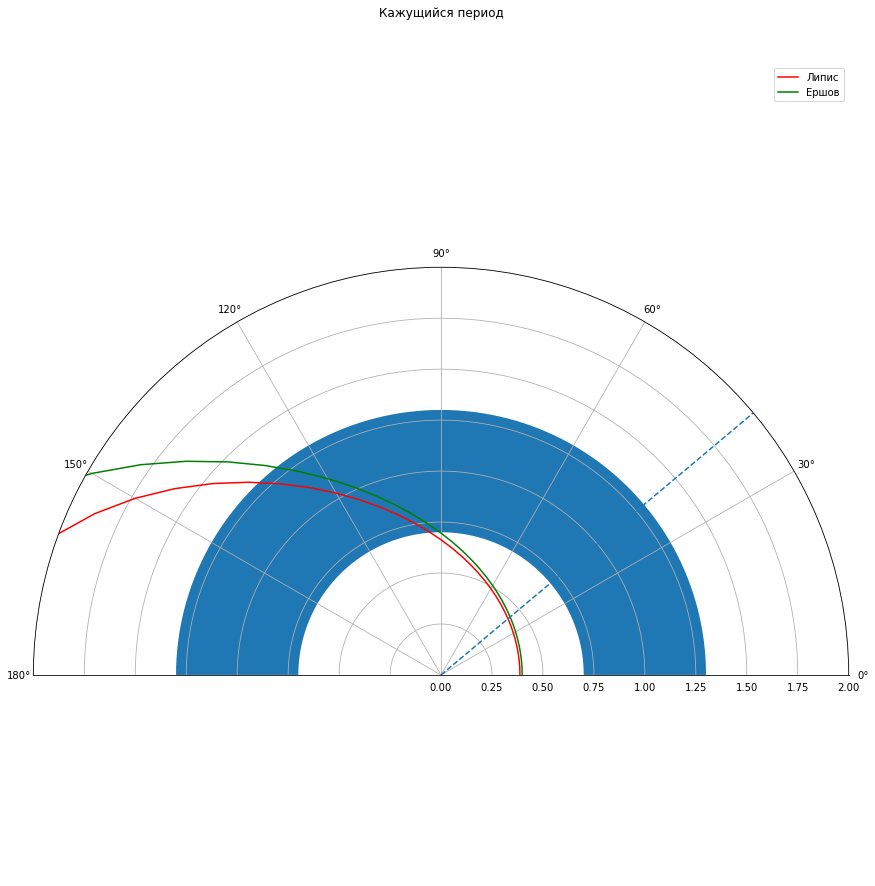

In [74]:
# print(taus_app_0)

plt.figure(figsize=[20,15])
ax = plt.subplot(111, projection = 'polar')
# ax.set_xlim(0,pi)
ax.set_ylim(0,2)
ax.plot(wave_angles/180*pi, taus_app_0/t_teta, label='Липис', color='red')
ax.plot(wave_angles/180*pi, taus_app_1/t_teta, label='Ершов', color='green')
ax.legend(loc='best')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30/180*pi))
ax.set_thetamax(180)
ax.add_patch(patches.Rectangle((0, 0.7), width=pi, height=0.6))
ax.bar(0, 1).remove()
ax.set_axis_on()
ax.axvline(40/180*pi, linestyle='--')
# ax.set_rlabel_position(10.5)
# ax.set_label('')
ax.set_title('Кажущийся период'); 

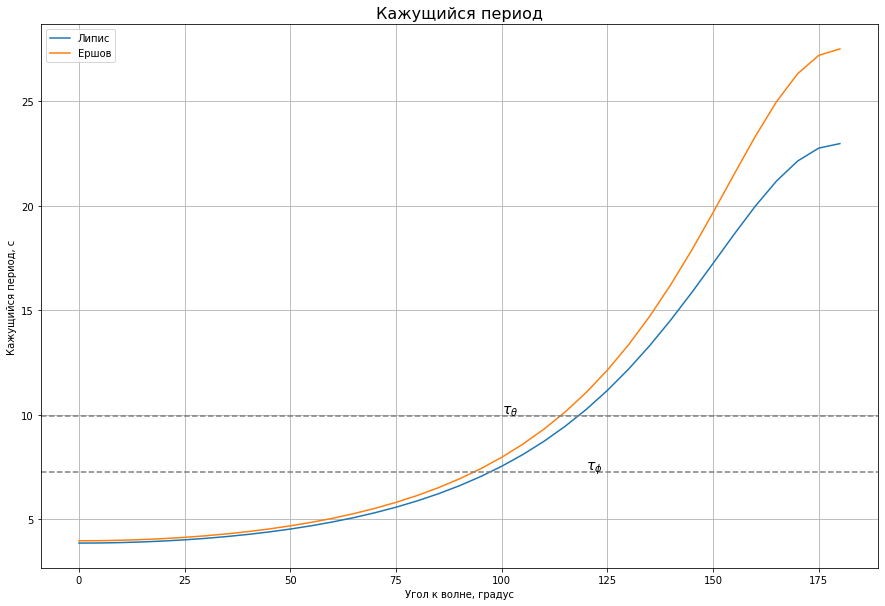

In [75]:
plt.figure(figsize=[15,10])
plt.plot(wave_angles, taus_app_0, label='Липис')
plt.plot(wave_angles, taus_app_1, label='Ершов')
plt.title('Кажущийся период', fontsize=16)
plt.xlabel('Угол к волне, градус' )
plt.ylabel('Кажущийся период, с' )
plt.axhline(t_teta, color='gray', linestyle='--')
plt.annotate(r'$\tau_\theta$',xy=(100,t_teta+0.1), fontsize=14)


plt.axhline(t_fi, color='gray', linestyle='--')
plt.annotate(r'$\tau_\phi$',xy=(120,t_fi+0.1), fontsize=14)

# plt.ylim (0,15)


plt.grid()
plt.legend(loc='best');

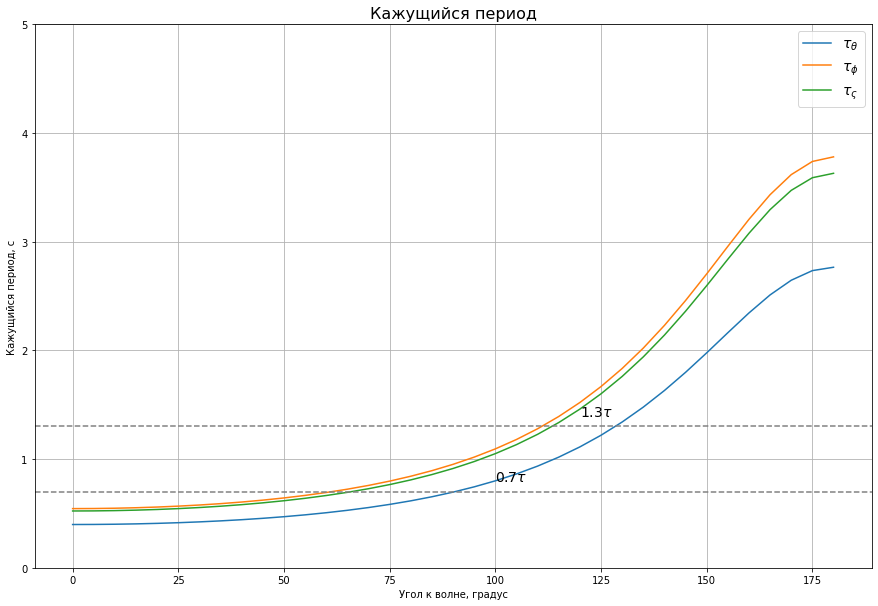

In [76]:

plt.figure(figsize=[15,10])
# plt.plot(wave_angles, taus_app_0/t_teta, label='Липис')
plt.plot(wave_angles, taus_app_1/t_teta, label=r'$\tau_\theta$')
plt.plot(wave_angles, taus_app_1/t_fi, label=r'$\tau_\phi$')
plt.plot(wave_angles, taus_app_1/t_dzeta, label=r'$\tau_\varsigma$')

plt.title('Кажущийся период', fontsize=16)
plt.xlabel('Угол к волне, градус' )
plt.ylabel('Кажущийся период, с' )
plt.axhline(0.7, color='gray', linestyle='--')
plt.annotate(r'$0.7\tau$',xy=(100,0.7+0.1), fontsize=14)

plt.axhline(1.3, color='gray', linestyle='--')
plt.annotate(r'$1.3\tau$',xy=(120,1.3+0.1), fontsize=14)

plt.ylim (0,5)


plt.grid()
plt.legend(loc='best',fontsize=14);

## Литература
1. В.Б. Липис, Ю.В. Ремез Безопасные режимы штормового плавания судов
1. Л.А. Козырь, Л.Р. Аксютин Управление судами в шторм
1. А.А. Ершов, С.В. Сольнов, А.М. Бояринов Диаграмма для определения опасных областей при движении судна в штормовом море
1. Б.В. Бекенский Практические расчеты мореходных качеств судна
1. И.К. Бородай, Ю.А. Нецветаев Мореходность судов
1. Правила классификации и постройки морских судов 2018 // Российский Морской Регистр Судо-
ходства Ч. IV. Остойчивость.